In [4]:
set([5,3,6,1,0])

{0, 1, 3, 5, 6}

In [2]:
# Import all the tools we need

# Regular EDA (Exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We want our plots to appear inside the notebook
%matplotlib inline

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve, roc_auc_score, roc_curve

In [56]:
# Importing dataset
df = pd.read_csv('train.csv')
X = df.drop('Attrition', axis=1)
y = df['Attrition']
X = pd.get_dummies(X)

In [57]:
# Preprocessing X 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

X = pd.get_dummies(X)
X = X.drop(['Id', 'Behaviour'], axis=1)


sc_X = StandardScaler()
X_train = sc_X.fit_transform(X)

# Importing and Preprocessing X_test
Xtest = pd.read_csv("test.csv")

Xtest = pd.get_dummies(Xtest)
Xtest = Xtest.drop(["Id", "Behaviour"], axis=1)
X_test = sc_X.transform(Xtest)

# Split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y, test_size = 0.2)

# Testing Different Models

In [12]:
# Put models in a dictionary
models = {"Logistic Regression": LogisticRegression(),
          "KNN": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier(),
          "SVM_lin": SVC(kernel="linear", probability=True),
          "SVM_rbf": SVC(kernel="rbf", probability=True)}

# Create a function to fit and score the models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluate given machine learning models.
    models : a dict of different Scikit-Learn machine learning models
    X_train : training data (no labels)
    X_test : testing data (no labels)
    y_train : training labels
    y_test : testing labels
    """
    # Set random seed
    np.random.seed(42)
    # Make a dictionary to keep model scores
    model_scores = {}
    model_aucs = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
        # Evaluate AUC score
        model_aucs[name] = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        
    return model_scores, model_aucs    


Xtrain, X_test, y_train, y_test = train_test_split(X_train, y, test_size = 0.2)

model_scores, model_aucs = fit_and_score(models, Xtrain, X_test, y_train, y_test)

print("Model scores ", model_scores)
print("Model auc scores ", model_aucs)

Model scores  {'Logistic Regression': 0.745398773006135, 'KNN': 0.7975460122699386, 'Random Forest': 0.9539877300613497, 'SVM_lin': 0.7730061349693251, 'SVM_rbf': 0.8895705521472392}
Model auc scores  {'Logistic Regression': 0.8356480605487229, 'KNN': 0.8725449385052034, 'Random Forest': 0.9980132450331126, 'SVM_lin': 0.8396594134342479, 'SVM_rbf': 0.9603405865657522}


So we got two best models those are:
* Random Forest Classifier
* SVM with rbf kernel

## Random Forest Classifier

In [20]:
rf_clf = RandomForestClassifier().fit(X_train, y_train)
y_probs = rf_clf.predict_proba(X_train)[:, 1]

In [18]:
# Splitting into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X_train, y, test_size = 0.2)

In [21]:
y_probs = rf_clf.predict_proba(X_test)[:, 1]
y = y_test

## SVM "rbf" Kernel

In [84]:
classifier = SVC(kernel='rbf', probability=True, C=1.2, gamma=.0153).fit(X_train, y_train)
y_probs = classifier.predict_proba(X_test)[:, 1]

# Evaluating Model

ROC-AUC score:  0.9601135288552507


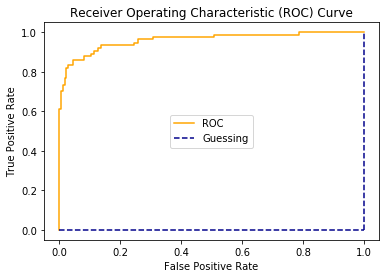

CrossValidated Score:  0.8793882072256306
161   14   21   130
Accuracy:  0.8926380368098159
Precision:  0.9027777777777778
Recall: 0.8609271523178808
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       175
           1       0.90      0.86      0.88       151

    accuracy                           0.89       326
   macro avg       0.89      0.89      0.89       326
weighted avg       0.89      0.89      0.89       326



In [83]:
# Calculate fpr, tpr and thresholds
fpr, tpr, thresholds = roc_curve(y_valid, y_probs)

print("ROC-AUC score: ", roc_auc_score(y_valid, y_probs))

def plot_roc_curve(fpr, tpr):
    """
    Plots a ROC curve given the false positve rate (fpr) and 
    true postive rate (tpr) of a classifier.
    """
    # Plot ROC curve
    plt.plot(fpr, tpr, color='orange', label='ROC')
    # Plot line with no predictive power (baseline)
    plt.plot([0, 1], [0, 0], color='darkblue', linestyle='--', label='Guessing')
    plt.plot([1, 1], [0, 1], color='darkblue', linestyle='--')
    # Customize the plot
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

plot_roc_curve(fpr, tpr)

print("CrossValidated Score: ", cross_val_score(classifier, X_train, y_train, cv=8).mean())

# Confusion matrix
y_pred = (y_probs > .5)
tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
print(tn, " ", fp, " ", fn, " ", tp)
print("Accuracy: ", (tp+tn)/(tp+fp+tn+fn))
print("Precision: ", tp/(tp+fp))
print("Recall:", tp/(tp+fn))
print(classification_report(y_valid, y_pred))

# Converting to csv

In [25]:
submission = 7

In [85]:
# Turning results into csv file
data = {"Id": pd.read_csv("test.csv")["Id"],
        "Attrition": y_probs}
predictions = pd.DataFrame(data, columns = ["Id", "Attrition"]).to_csv(f"Submissions/SubmissionNew.csv", index=False)

In [20]:
classifier.coef_

array([[-0.15936926, -0.0233047 ,  0.29594899,  0.285535  , -0.01385439,
         0.16300149, -0.01017248, -0.36849694,  0.10063919, -0.3980148 ,
         0.07256567, -0.37067225,  0.2346482 , -0.57704793,  0.25543425,
         0.91686847,  0.02150794, -0.0803769 , -0.29102172, -0.14574842,
        -0.22182501,  0.22840403, -0.6295052 ,  0.54523813, -0.3015098 ,
         0.35951747]])

In [24]:
# Match coef's of features to columns
feature_dict = dict(zip(df.columns, list(classifier.coef_[0])))

NameError: name 'classifier' is not defined

In [23]:
# Visualize feature importance
feature_df = pd.DataFrame(feature_dict, index = [0])
feature_df.T.plot.bar(title="Feature Importance", legend=False);

NameError: name 'feature_dict' is not defined

## Finding correlations using Correlation matrix

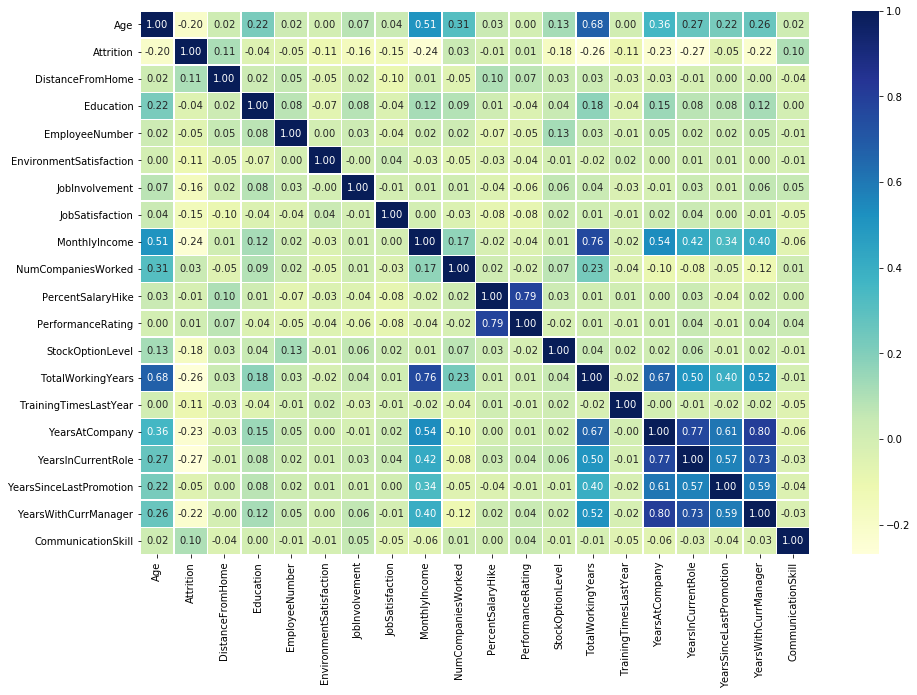

In [24]:
# Let's make our correlation matrix a little prettier
import seaborn as sns
corr_matrix = df.drop(["Id", "Behaviour"], axis=1).corr()
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidth=0.5,
                 fmt=".2f",
                 cmap="YlGnBu");

In [78]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
# Splitting into train and test datasets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

grid = {"C": np.logspace(-4,4,20), 
        "max_iter": [100, 1000, 2500, 5000],
        "solver": ['liblinear', 'lbfgs', 'sag', 'saga'],
        "penalty": ['l1', 'l2', 'elasticnet', 'none']
       }# l1 lasso l2 ridge

logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, grid, cv=10, verbose=True, n_jobs=-1)
logreg_cv.fit(X, y)

print("Tuned hpyerparameters :(best parameters) ", logreg_cv.best_params_)
print("Accuracy :", logreg_cv.best_score_)

Fitting 10 folds for each of 1280 candidates, totalling 12800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 4624 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 12702 tasks      | elapsed:   24.6s


Tuned hpyerparameters :(best parameters)  {'C': 0.08858667904100823, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
Accuracy : 0.7629061576914338


[Parallel(n_jobs=-1)]: Done 12800 out of 12800 | elapsed:   24.8s finished


In [79]:
logreg_cv.best_params_

{'C': 0.08858667904100823, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}

In [80]:
logreg_cv.best_estimator_

LogisticRegression(C=0.08858667904100823, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [83]:
y_probs = logreg_cv.predict_proba(X_test)[:,1]

In [ ]:
GridSearchCV()